# Kalman Filter for Bike Lean Angle Estimation

The first try would be to use the gravitational force and just point the phone to the ground.

Doesn't work on bikes, because they are leaning in exactly this angle, which is needed to compensate the gravitational force with the centrifugal force.

![Bike Lean](https://upload.wikimedia.org/wikipedia/en/8/87/BikeLeanForces3.PNG)

One has to use two different sensors:

1. a rotationrate sensor for lean angle
2. a acceleration sensor for gravitional force

Both sensors have to be fused to estimate the lean angle. This is done with a Kalman Filter. We are using [Sympy](http://www.sympy.org/de/) do develop this filter.

In [13]:
import numpy as np
from sympy import Symbol, symbols, Matrix, sin, cos, acos, pi
from sympy.abc import phi, g, a
from sympy import init_printing
init_printing(use_latex=True)

The state vector to describe the state of the bike consists of two variables:

$$\vec x= \left[ \matrix{ \phi \\ \dot \phi} \right]$$

which is the lean angle $\phi$ (in radian) and the lean angle rate $\dot \phi$ (in radian per second).

In [14]:
phis = symbols('phi')
dphis = Symbol('\dot \phi')
Ts = symbols('T')

In [15]:
state = Matrix([phis, dphis])
state

⎡    φ    ⎤
⎢         ⎥
⎣\dot \phi⎦

## Kalman Filter Prediction Step: System Dynamics

But the state is driven by the lean angle rate $\dot \phi$ (in radian per second). So the Kalman Filter Equation for the Prediction Step is:

$$\vec x_{k+1} = A \cdot \vec x_{k}$$

The dynamic matrix $A$ is simply:

$$A = \left[ \matrix{ 1 & \Delta T \\ 0 & 1 } \right]$$

with $\Delta T$ as the time between two filtersteps (the sample time of the discrete Kalman Filter).

In [16]:
Q = np.diag([0.1, 1.0])

## Kalman Filter Update Step: Sensors

We have two kind of sensors, which are usually available within a 6 Degrees of Freedom Inertial Measurement Unit (6DoF IMU):

1. rotationrate sensor
2. acceleration sensor

The rotationrate sensor is measuring $\dot \phi$ directly, the acceleration sensor is measuring the gravitation, so not directly the lean angle $\phi$. There is a mathematical link between the lean angle and the vertical acceleration $a$ measured by the acceleration sensor. It is the *cosine*. If the bike is upright, the acceleration $a$ is exactly $1g$, if it is $\phi=90^\circ$, it is $0g$.

$$a = g \cdot \cos(90^\circ - \phi)$$

so the measurement function $z(x)$ is

$$\phi = 90^\circ - \arccos \left(\frac{a}{g}\right)$$

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

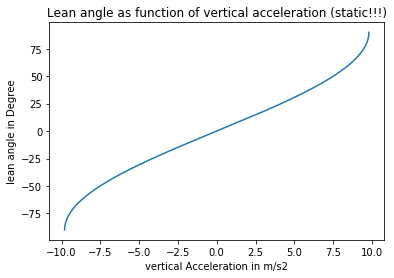

In [18]:
a=np.linspace(-9.81, 9.81, 1000)
plt.plot(a, 90-np.arccos(a/9.81)*180.0/np.pi)
plt.xlabel('vertical Acceleration in m/s2')
plt.ylabel('lean angle in Degree')
plt.title('Lean angle as function of vertical acceleration (static!!!)')

## Load some Measurements

In [3]:
import pandas as pd
from py import *

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
cd '~/bike-signal/recordings/controlled_experiments/recordings'

/Users/ankush/bike-signal/recordings/controlled_experiments/recordings


In [5]:
data = loadData('experiment_data.pkl')

In [6]:
dt = 1e-1 # Hz

In [7]:
data.keys()

['201708191910',
 '201708191914',
 '201708191915',
 '201708191916',
 '201708191918',
 '201708191921',
 '201708191922',
 '201708191927',
 '201708191929',
 '201708192017',
 '201708192019']

In [36]:
t = data['201708191910'].index
a_meas = data['201708191910'][['lastAccelerometerValues[0]']].values*-9.81 # in m/s2
a_meas[a_meas>9.81] = 9.81
a_meas[a_meas<-9.81] = -9.81
dphi_meas = data['201708191910'][['lastGyroscopeValues[1]']].values # in rad/s

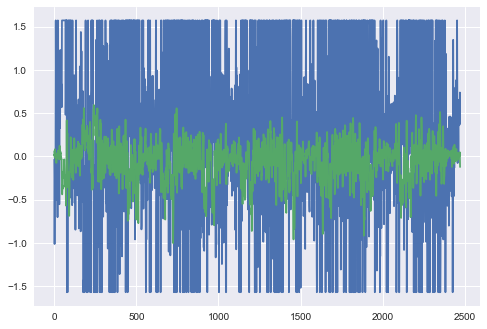

In [37]:
plt.plot(np.pi/2-np.arccos(a_meas/9.81))
plt.plot(dphi_meas)
plt.show()


# Kalman Filter

![Kalman Filter Step](Kalman-Filter-Step.png)

In [34]:
x = np.matrix([[0.0],
               [0.0]]) # Initial State
A = np.matrix([[1.0, dt], [0.0, 1.0]])
H = np.diag([1.0, 1.0])
P = np.diag([100.0, 1.0])
I = np.diag([1.0, 1.0])

In [35]:
x0=[]
x1=[]
P0=[]
dstate=[]
for filterstep in range(len(data)):
 
    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    x = A*x
    
    # Project the error covariance ahead
    P = A*P*A.T + Q
    
    
    # Measurement Update (Correction)
    # ===============================
    # Compute the Kalman Gain
    
    # Measurement Noise is adaptive:
    # Assuming a pretty correct angle measurement, while the
    # bike is upright (vertical acceleration is nearly 1g),
    # and a pretty bad estimation while the bike is leaning.
    # So we make the R value adaptive to the lean angle
    # with low values while upright and high values for high
    # leaning angles.
    adaptivephi = np.abs(np.multiply(1000.0,float(x[0]))+0.001)
    R = np.diag([adaptivephi, 0.001])


    S = H*P*H.T + R
    K = (P*H.T) * np.linalg.pinv(S)

    
    # Update the estimate via z
    Z = np.matrix([[np.pi/2-np.arccos(a_meas[filterstep]/9.81)],
                   [dphi_meas[filterstep]]])

    y = Z - (H*x)                            # Innovation or Residual
    x = x + (K*y)
    
    # Update the error covariance
    P = (I - (K*H))*P



    # Save states for Plotting
    x0.append(float(x[0]))
    x1.append(float(x[1]))
    P0.append(float(P[0,0]))

NameError: name 'Q' is not defined

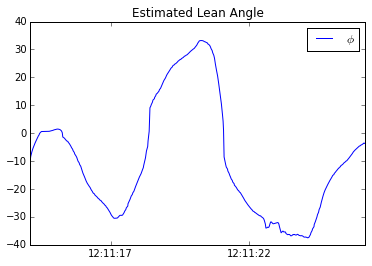

In [742]:
plt.plot(t,np.multiply(x0,180.0/np.pi), label=r'$\phi$')
#plt.plot(t,x1, label=r'$\dot \phi$')
#plt.plot(t, dphi_meas,label=r'$\dot \phi$ (ref)', alpha=0.5)
plt.title('Estimated Lean Angle')
plt.legend()